In [ ]:
# This program creates a CNN model to identify pneumonia in x-ray images of lungs
import keras
from keras import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import *
from keras.layers.normalization import BatchNormalization
from keras.metrics import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import cv2
from matplotlib import pyplot
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This function loads data from the speficied paths and 
# applies the specified augmentations
def load_data():
   trainDataPath = '/content/drive/MyDrive/chest_xray/train'
   testDataPath = '/content/drive/MyDrive/chest_xray/test'
   valDataPath = '/content/drive/MyDrive/chest_xray/val'

   trainDataGen = ImageDataGenerator(rescale=1.0/255.0, horizontal_flip=True, 
                                     brightness_range=[0.3,1.0])
   testDataGen = ImageDataGenerator(rescale=1.0/255.0)
   valDataGen = ImageDataGenerator(rescale=1.0/255.0)

   trainData = trainDataGen.flow_from_directory(trainDataPath, 
                                                target_size=(224, 224), 
                                                classes=['NORMAL', 'PNEUMONIA'], 
                                                batch_size=32)
   testData = testDataGen.flow_from_directory(testDataPath, 
                                              target_size=(224, 224), 
                                              classes=['NORMAL', 'PNEUMONIA'], 
                                              batch_size=32)
   valData = valDataGen.flow_from_directory(valDataPath, target_size=(224, 224), 
                                            classes=['NORMAL', 'PNEUMONIA'], 
                                            batch_size=32)
   return trainData, testData, valData

In [ ]:
# This function adds the specified layers to build the model and compiles
# the model with the chosen optimizer and loss functions.
# The callbacks that dictate early stopping and checkpoint saving are returned
def build_model():
  model = Sequential([Conv2D(32, (3, 3), activation='relu', 
                             input_shape=(224, 224, 3))])
  model.add(MaxPooling2D(2, 2))
  model.add(Conv2D(32, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Conv2D(64, (3,3), activation='relu'))
  model.add(MaxPooling2D(2, 2))
  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(2, activation='softmax'))
  # Used for early stopping and to save checkpoint but excluded from final model
  callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, 
                           verbose=0, mode="auto", baseline=None, 
                           restore_best_weights=False), 
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', 
                             save_best_only=True)]
  model.summary()

  model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', 
                metrics='accuracy')
  model.save('/content/drive/MyDrive/chest_xray/')

  return model
  
build_model()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 64)       

In [ ]:
# Trains the model for the specified parameters
def train(model, trainData, valData):
  history = model.fit(trainData, validation_data=valData, steps_per_epoch=10,  
                      epochs=10, verbose=1)
  return history

In [ ]:
# Evaluates the model and returns results
def evaluate(model, testData):
  results = model.evaluate(testData)
  return results

In [ ]:
# Prints the graph of the accuracy results
def print_acc_results(history, results):
  # Shows graph of accuracy with training and validation curves
  pyplot.figure()
  pyplot.plot(history.history['accuracy'])
  pyplot.plot(history.history['val_accuracy'])
  pyplot.ylabel('accuracy')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'val'], loc='upper left')

In [ ]:
# Prints the graph of the loss results
def print_loss_results(history, results):
  # Shows graph of loss with training and validation curves
  pyplot.figure()
  pyplot.plot(history.history['loss'])
  pyplot.plot(history.history['val_loss'])
  pyplot.ylabel('loss')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'val'], loc='upper left')
  pyplot.show

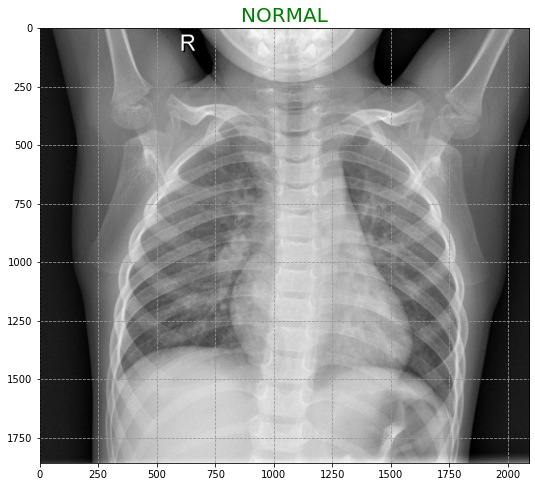

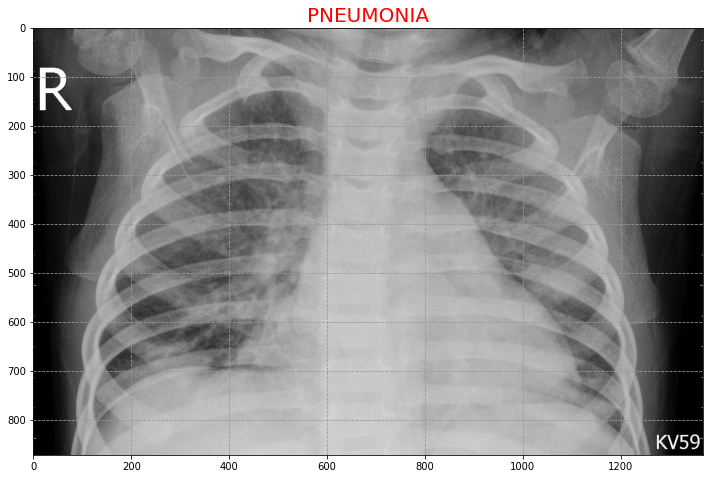

In [ ]:
def visualizer():
  # Firstly show how a Normal lung
  # should look like
  plt.figure(figsize=(12,8))
  img = load_img('/content/drive/MyDrive/chest_xray/train/NORMAL/IM-0115-0001.jpeg')
  plt.imshow(img)
  plt.title("NORMAL", color = "green", size = 20)
  plt.grid(color='#999999', linestyle='--')
  plt.show()

  print('\n \n \n')

  # Secondly we see how infected lungs look like : 
  plt.figure(figsize=(12,8))
  img = load_img('/content/drive/MyDrive/chest_xray/train/PNEUMONIA/person1026_virus_1718.jpeg')
  plt.imshow(img)
  plt.title("PNEUMONIA", color = "red", size = 20)
  plt.grid(color='#999999', linestyle = '--')
  plt.show()
visualizer()

In [ ]:
import numpy as np
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pandas as pd

# Confusion matrix is used to describe the performance of the classification 
# model that we are using to detect Pneumonia in x-rays.

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
validation_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/chest_xray/test',
                                                        target_size=(224, 224), 
                                                        classes=['NORMAL', 'PNEUMONIA'], 
                                                        batch_size=50)
model = build_model()

Y_pred = model.predict_generator(validation_generator, 624 // 50 + 1)
y_pred = np.argmax(Y_pred, axis = 1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))


Found 627 images belonging to 2 classes.
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_31 (Co

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


Confusion Matrix
[[  1 234]
 [  3 389]]


In [ ]:
# Runs the entirety of the program
def main():
  train_data, test_data, val_data = load_data()
  model = build_model()
  history = train(model, train_data, val_data)
  results = evaluate(model, test_data)
  print_acc_results(history, results)
  print_loss_results(history, results)

In [ ]:
main()

In [ ]:
# EXTRA - Check a chest xray image for pneumonia infection

def image_classifier():
  # load necessary libs
  from keras.models import load_model
  from keras.preprocessing import image
  from keras.applications.vgg16 import preprocess_input
  import numpy as np

  # Retrieve model
  model = load_model('/content/drive/MyDrive/chest_xray')

  # Select image (Provide path and name.imageType)
  # resize 
  img = image.load_img('/content/drive/MyDrive/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg',target_size=(224,224))

  # Process image
  # Get pixels into np 2d array
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  # use builtin functions
  img_data = preprocess_input(x)
  classes = model.predict(img_data)

  # Get result and prob
  print(classes)

  result=classes[0][0]
  # From the data we have, we conclude the following if-else
  # clause that prints the final result.

  if result <= 0.1:
      print("PNEUMONIA")
  else:
      print("NORMAL")

image_classifier()

[[9.9923885e-01 7.6112052e-04]]
NORMAL


In [ ]:
## OPTIONAL 
## LOAD THE KAGGLE DATASET INTO DIRECTORY
## REMOVE THE # TO RUN

# ! pip install -q kaggle

# from google.colab import files
# files.upload()

# ## Here, you should download the json file from your
# ## personal kaggle account

# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list
# ! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
# ! mkdir train
# ! unzip train.zip -d train